In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.retinotopy import convert_coords as coords

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import retino_structure as ret
from pipeline.python.classifications import rf_utils as rfutils

from pipeline.python.classifications import aggregate_data_stats as aggr

from pipeline.python.utils import natural_keys, label_figure, convert_range

from matplotlib.lines import Line2D


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/fit_2d_rfs.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/rois/utils.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/hom

In [2]:
%matplotlib notebook


# Set color schemes by visual area

In [3]:
# visual_areas = ['V1', 'Lm', 'Li']
# colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
# area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}
visual_areas = ['V1', 'Lm', 'Li']
colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

#### Plot params
pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

dpi = 150

In [4]:
def set_split_xlabels(ax, offset=0.25, a_label='rfs', b_label='rfs10'):
    ax.set_xticks([0-offset, 0+offset, 1-offset, 1+offset, 2-offset, 2+offset])
    ax.set_xticklabels([a_label, b_label, a_label, b_label, a_label, b_label])
    ax.set_xlabel('')
    ax.tick_params(axis='x', size=0)
    sns.despine(bottom=True, offset=4)
    return ax

# Set dataset parameters

In [5]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Preprocessing params
responsive_test = None
responsive_thr = None
n_stds = None

#### RF fit params
response_type = 'dff'
fit_thr=0.5

#### Set outputdir for current analysis
fit_desc = fitrf.get_fit_desc(response_type=response_type)
outdir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, fit_desc))
if not os.path.exists(outdir):
    os.makedirs(outdir)
print("... saving output to base dir:\n%s" % outdir)

#### Create data ID for labeling figures with data-types
data_desc = '%s-%s' % (traceid, fit_desc)
data_id = '|'.join([data_desc, '%s-thr-%.2f' % (fit_desc, fit_thr)])
print("DATA ID: %s" % data_id)

... saving output to base dir:
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff
DATA ID: traces001-fit-2dgaus_dff-no-cutoff|fit-2dgaus_dff-no-cutoff-thr-0.50


# Control: check 'rfs' vs. 'rfs10'

In [6]:
#### Create current output dir
compare_dir = os.path.join(outdir, 'general-stats', 'rfs_v_rfs10_2')
if not os.path.exists(compare_dir):
    os.makedirs(compare_dir)
print compare_dir

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10_2


#### Load data

In [7]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)

In [8]:
# Get data sets where rfs and rfs10 were tested
ctl_dsets = pd.concat([dg[dg['experiment'].isin(['rfs', 'rfs10'])] for dkey, dg in sdata.groupby(['animalid', 'session', 'fovnum']) \
            if 'rfs' in dg['experiment'].values and 'rfs10' in dg['experiment'].values], axis=0).reset_index(drop=True)
ctl_dsets.groupby(['visual_area'])['experiment'].value_counts()

visual_area  experiment
Li           rfs           4
             rfs10         4
Lm           rfs           1
             rfs10         1
V1           rfs           4
             rfs10         4
Name: experiment, dtype: int64

In [9]:
# Aggregate all fit data into dataframe
scale_sigma = True
reliable_only = True

dpaths, _ = rfutils.get_fit_dpaths(ctl_dsets, fit_desc=fit_desc, traceid=traceid,) # get datapths
tmpdf = rfutils.aggregate_rf_data(dpaths,  fit_desc=fit_desc, traceid=traceid,
                                  reliable_only=reliable_only,
                                  fit_thr=fit_thr, scale_sigma=scale_sigma, verbose=False) # load dataframes
df = tmpdf[tmpdf['r2']>fit_thr] # Filter to make sure all good fits

df.groupby(['visual_area', 'experiment']).count()


N dpaths: 18, N unfit: 0
N datasets included: 18, N sessions excluded: 0


r2  fwhm_x  fwhm_y  theta   x0   y0  animalid  cell  \
visual_area experiment                                                         
Li          rfs          72      72      72     72   72   72        72    72   
            rfs10       125     125     125    125  125  125       125   125   
Lm          rfs          14      14      14     14   14   14        14    14   
            rfs10        28      28      28     28   28   28        28    28   
V1          rfs         241     241     241    241  241  241       241   241   
            rfs10       442     442     442    442  442  442       442   442   

                        datakey  fovnum  session  std_x  std_y  fwhm_avg  \
visual_area experiment                                                     
Li          rfs              72      72       72     72     72        72   
            rfs10           125     125      125    125    125       125   
Lm          rfs              14      14       14     14     14        14   
            rfs10            28      28       28     28     28        28   
V1          rfs             241     241      241    241    241       241   
            rfs10           442     442      442    442    442       442   

                        std_avg  area  
visual_area experiment                 
Li          rfs              72    72  
            rfs10           125   125  
Lm          rfs              14    14  
            rfs10            28    28  
V1          rfs             241   241  
            rfs10           442   442

In [10]:
df.shape

(922, 18)

In [21]:
reload(rfutils)

<module 'pipeline.python.classifications.rf_utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/rf_utils.py'>

## Check size of RFs by x/y

In [13]:
fx = abs(df[['std_x', 'std_y']].max(axis=1) * np.cos(df['theta']))
fy = abs(df[['std_x', 'std_y']].max(axis=1) * np.sin(df['theta']))

df['fx'] = fx
df['fy'] = fy

<IPython.core.display.Javascript object>


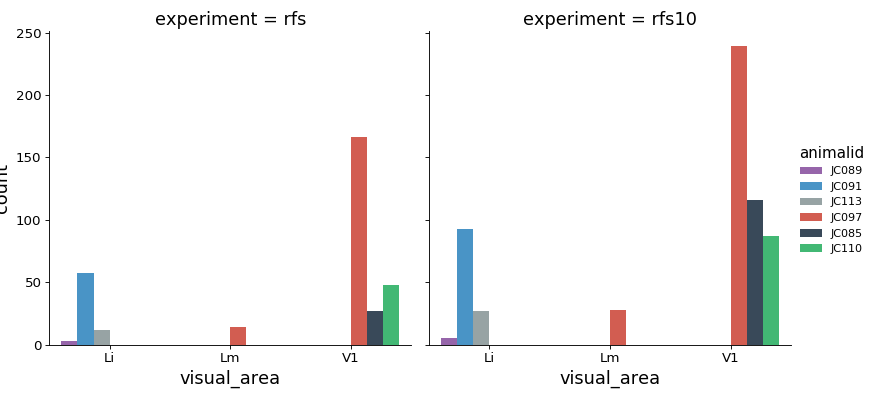

,r2,fwhm_x,fwhm_y,theta,x0,y0,animalid,cell,datakey,experiment,fovnum,session,std_x,std_y,fwhm_avg,std_avg,area,fx,fy
visual_area,,,,,,,,,,,,,,,,,,,
Li,197,197,197,197,197,197,197,197,197,197,197,197,197,197,197,197,197,197,197
Lm,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42
V1,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683,683


In [14]:
sns.catplot(x='visual_area', hue='animalid', col='experiment',  data=df, kind='count')
df.groupby(['visual_area']).count()

## Test: x + y components of vector spanned by ellipse (major)

In [17]:
datakey = '20190622_JC085_fov1'
rid=25
sz_metric = 'std'

#params=['r2', 'sigma_x', 'sigma_y', 'theta', 'x0', 'y0', 'datakey', 'cell', 'experiment', 'avg_size', 'fx', 'fy']
params=['r2', '%s_x' % sz_metric, '%s_y' % sz_metric, 'theta', 
        'x0', 'y0', 'datakey', 'cell', 'experiment', '%s_avg' % sz_metric, 'fx', 'fy']

df[(df['datakey']==datakey) & (df['cell']==rid)][params]

,r2,std_x,std_y,theta,x0,y0,datakey,cell,experiment,std_avg,fx,fy
9,0.663539,8.261852,11.873748,2.573175,35.90598,-4.720554,20190622_JC085_fov1,25,rfs10,10.0678,10.006644,6.391632


237.777484979


<IPython.core.display.Javascript object>


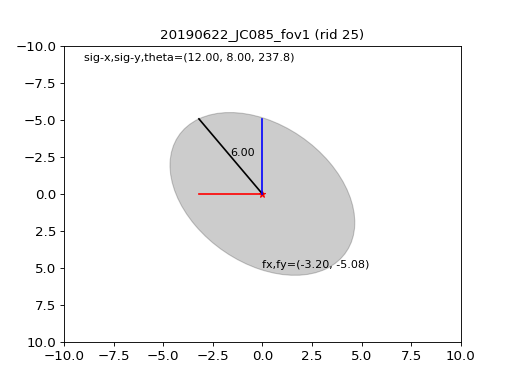

(-3.2, -5.08)


In [16]:
from matplotlib.patches import Ellipse

x0, y0 = (0, 0)
M = 12 #10
m = 8 #3

theta = np.rad2deg(4.15)
print(theta)
angle = np.deg2rad(theta)

fig, ax = pl.subplots() #pl.figure()
ax.plot(x0, y0, 'r*')

el = Ellipse((x0, y0), width=M, height=m, angle=theta, alpha=0.2, color='k')
ax.add_artist(el)


ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])

F = M/2.

xe = F * np.cos(np.deg2rad(theta))
ye = F * np.sin(np.deg2rad(theta))
ax.plot([x0, xe], [y0, ye], 'k')
ax.text(xe/2., ye/2., '%.2f' % F)

fx = round(F * np.cos(np.deg2rad(theta)), 2)
fy = round(F * np.sin(np.deg2rad(theta)), 2)
print(fx, fy)

ax.text(0, 5, 'fx,fy=(%.2f, %.2f)' % (fx, fy))
ax.text(-9, -9, 'sig-x,sig-y,theta=(%.2f, %.2f, %.1f)' % (M, m, theta))
ax.plot([x0, fx], [y0, y0], 'r')
ax.plot([x0, x0], [y0, fy], 'b')


ax.set_title('%s (rid %i)' % (datakey, rid))

ax.invert_yaxis()

## Plot x- and y-components of fit RFs

<IPython.core.display.Javascript object>


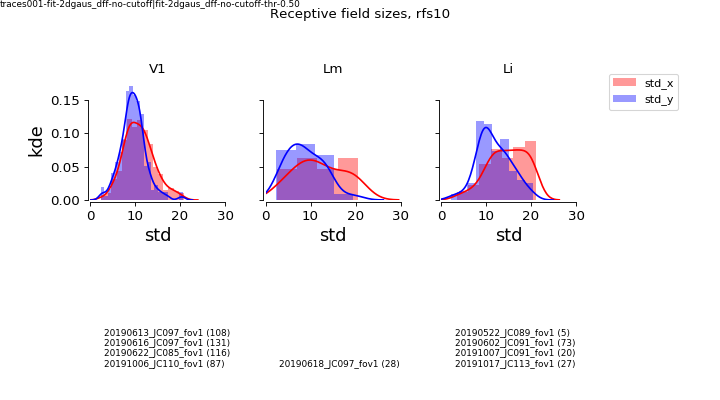

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10_2', 'split_std_xy_std_rfs10')


In [22]:
split_components = False
experiment = 'rfs10'

x_color = 'r'
y_color = 'b'

_df = df[df['experiment']==experiment].copy()

xlim = 60 if sz_metric=='fwhm' else 30
component_str = 'f' if split_components else '%s_' % sz_metric

visual_areas = ['V1', 'Lm', 'Li']


offset=0
fig, axes = pl.subplots(1,3, figsize=(9,5), sharey=True, sharex=True)
pl.subplots_adjust(wspace=0.3, right=0.8, top=0.8, bottom=0.5)

for ax, visual_area in zip(axes.flat, visual_areas):
    g = _df[_df['visual_area']==visual_area].copy()
    
    sns.distplot(g['%sx' % component_str], color=x_color, ax=ax, label='%sx' % component_str)
    sns.distplot(g['%sy' % component_str], color=y_color, ax=ax, label='%sy' % component_str)
    ax.set_title(visual_area)
    count_str = '\n'.join(['%s (%i)' % (dkey, len(d)) for dkey, d in g.groupby(['datakey'])])
    #ax.set_ylim([0, 0.1])
    ax.set_xlim([0, xlim])
    ax.text(3, -0.25, count_str, fontsize=8)
    
    ax.set_xlabel(sz_metric)

sns.despine(trim=True, offset=2)
    
axes[0].set_ylabel('kde')
axes[2].legend(bbox_to_anchor=(1.8, 1.1))

label_figure(fig, data_id)
fig.suptitle('Receptive field sizes, %s' % experiment)

figname = 'split_%sxy_%s_%s' % (component_str, sz_metric, experiment)
pl.savefig(os.path.join(compare_dir, '%s_2.svg' % figname))
print(compare_dir, figname)

# Get cells fit for BOTH rfs and rfs10

In [27]:
def pairwise_compare_single_metric(comdf, curr_metric='avg_size', ax=None, marker='o'):

    offset = 0.25
    
    if ax is None:
        fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
        fig.patch.set_alpha(0)
        ax.patch.set_alpha(0)
    
    # Plot paired values
    aix=0
    for ai, visual_area in enumerate(visual_areas):

        plotdf = comdf[comdf['visual_area']==visual_area]
        a_vals = plotdf[plotdf['experiment']=='rfs'].sort_values(by='datakey')[curr_metric].values
        b_vals = plotdf[plotdf['experiment']=='rfs10'].sort_values(by='datakey')[curr_metric].values

        by_exp = [(a, e) for a, e in zip(a_vals, b_vals)]
        for pi, p in enumerate(by_exp):
            ax.plot([aix-offset, aix+offset], p, marker=marker, color=area_colors[visual_area], 
                    alpha=1, lw=0.5,  zorder=0, markerfacecolor=None, markeredgecolor=area_colors[visual_area])
        tstat, pval = spstats.ttest_rel(a_vals, b_vals)
        print("%s: (t-stat:%.2f, p=%.2f)" % (visual_area, tstat, pval))
        aix = aix+1

    # Plot average
    sns.barplot("visual_area", curr_metric, data=comdf, 
                hue='experiment', #zorder=0,
                ax=ax, order=visual_areas,
                errcolor="k", edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
    ax.legend_.remove()

    set_split_xlabels(ax, a_label='rfs', b_label='rfs10')
    
    return ax


In [29]:
curr_metric = 'std_avg'
common_rois = dict((dkey, np.intersect1d(d[d['experiment']=='rfs']['cell'], d[d['experiment']=='rfs10']['cell']))\
                     for dkey, d in df.groupby(['datakey']))

comdf = []
for visual_area, vdf in df.groupby(['visual_area']):
    currdf = pd.concat([g[g['cell'].isin(common_rois[dkey])] \
                        for dkey, g in vdf.groupby(['datakey'])], axis=0)

    a_vals = currdf[currdf['experiment']=='rfs'][curr_metric]
    b_vals = currdf[currdf['experiment']=='rfs10'][curr_metric]

    comdf.append(currdf)
    print("-----%s-------------------------" % visual_area)
    print("Paired t-test:")
    print spstats.ttest_rel(a_vals, b_vals) # Paired ttest (repeated measures)
    
    print("Wilcozon signed-rank (not assuming Gaussian):")
    print spstats.wilcoxon(a_vals, b_vals)   
    
comdf = pd.concat(comdf, axis=0)

-----Li-------------------------
Paired t-test:
Ttest_relResult(statistic=-2.0638199295340112, pvalue=0.046300031659835067)
Wilcozon signed-rank (not assuming Gaussian):
WilcoxonResult(statistic=214.0, pvalue=0.038045491392907325)
-----Lm-------------------------
Paired t-test:
Ttest_relResult(statistic=-0.58579188185691067, pvalue=0.57241013840660804)
Wilcozon signed-rank (not assuming Gaussian):
WilcoxonResult(statistic=23.0, pvalue=0.64646220266416965)
-----V1-------------------------
Paired t-test:
Ttest_relResult(statistic=-10.660732304010493, pvalue=2.550187425663074e-21)
Wilcozon signed-rank (not assuming Gaussian):
WilcoxonResult(statistic=2901.0, pvalue=9.8925822745271595e-19)


In [30]:
comdf.head()

,r2,fwhm_x,fwhm_y,theta,x0,y0,animalid,cell,datakey,experiment,fovnum,session,visual_area,std_x,std_y,fwhm_avg,std_avg,area,fx,fy
0,0.532335,40.932746,28.316740,0.285407,32.061522,-9.987968,JC091,15,20190602_JC091_fov1,rfs,1,20190602,Li,17.418190,12.049677,34.624743,14.733933,659.368636,16.713573,4.904061
1,0.723705,30.682715,19.030918,0.122968,30.405604,-7.293580,JC091,16,20190602_JC091_fov1,rfs,1,20190602,Li,13.056475,8.098263,24.856816,10.577369,332.175553,12.957885,1.601480
2,0.501710,30.976813,21.527211,0.367514,27.390515,-10.225962,JC091,24,20190602_JC091_fov1,rfs,1,20190602,Li,13.181622,9.160515,26.252012,11.171069,379.348738,12.301401,4.736107
3,0.709982,29.311060,24.789771,0.115117,31.994919,-7.388473,JC091,33,20190602_JC091_fov1,rfs,1,20190602,Li,12.472792,10.548839,27.050416,11.510815,413.350233,12.390239,1.432659
5,0.553642,32.808289,20.089325,0.317003,30.465034,-3.183316,JC091,36,20190602_JC091_fov1,rfs,1,20190602,Li,13.960974,8.548649,26.448807,11.254812,374.941125,13.265352,4.351922


## Average size by experiment-type (all fovs tested for control)

<IPython.core.display.Javascript object>


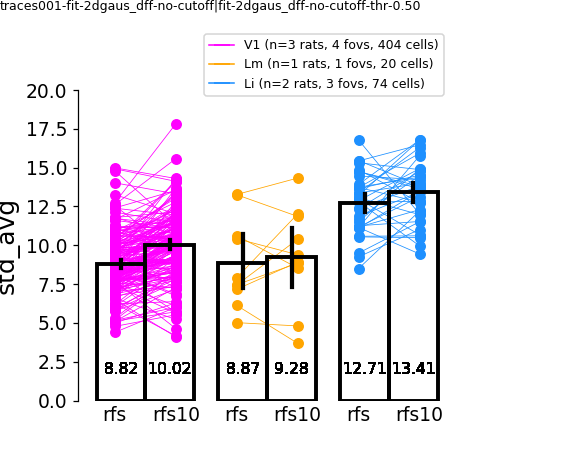

V1: (t-stat:-10.66, p=0.00)
Lm: (t-stat:-0.59, p=0.57)
Li: (t-stat:-2.06, p=0.05)
('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10_2', 'std_avg_pairwise_by-area')


In [37]:
sz_metric = 'std'

curr_metric = '%s_avg' % sz_metric


ylim = 60 if sz_metric=='fwhm' else 20.
offset = 0.25
marker= 'o'

fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax = pairwise_compare_single_metric(comdf, curr_metric=curr_metric, ax=ax)

df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10)
    
# Set x labels
ax.set_ylim([0, ylim])
set_split_xlabels(ax, a_label='rfs', b_label='rfs10')


pl.subplots_adjust(left=0.15, right=0.8, top=0.8)
label_figure(fig, data_id)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(comdf, area_colors=area_colors, markersize=10, marker='_')
ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.2), fontsize=8)


figname = '%s_pairwise_by-area' % (curr_metric)
pl.savefig(os.path.join(compare_dir, '%s_2.svg' % figname))

print(compare_dir, figname)

In [40]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

formula = 'std_avg ~ C(experiment) * C(visual_area)'
model = ols(formula, data=comdf).fit()
aov_table = sm.stats.anova_lm(model, typ=3)
aov_table

,sum_sq,df,F,PR(>F)
Intercept,5973.589124,1.0,1450.608648,7.933846e-149
C(experiment),9.228245,1.0,2.240960,1.350388e-01
C(visual_area),475.668978,2.0,57.755021,2.946210e-23
C(experiment):C(visual_area),6.240052,2.0,0.757658,4.693092e-01
Residual,2026.050136,492.0,NaN,NaN


In [42]:
model = ols('std_avg ~ visual_area + experiment', comdf).fit()
print(model.summary()) 

                            OLS Regression Results                            
Dep. Variable:                std_avg   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     80.57
Date:                Thu, 13 Aug 2020   Prob (F-statistic):           1.93e-42
Time:                        19:50:58   Log-Likelihood:                -1056.8
No. Observations:                 498   AIC:                             2122.
Df Residuals:                     494   BIC:                             2138.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              12.5127    

In [43]:
print(model.f_test([0, 1, -1, 0]))

<F test: F=array([[ 0.5522889]]), p=0.457737224125, df_denom=494, df_num=1>


In [44]:
result = ols(formula='std_avg ~ visual_area + experiment + visual_area * experiment', data=comdf).fit()    
print(result.summary())    

                            OLS Regression Results                            
Dep. Variable:                std_avg   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     48.60
Date:                Thu, 13 Aug 2020   Prob (F-statistic):           7.41e-41
Time:                        19:51:08   Log-Likelihood:                -1056.0
No. Observations:                 498   AIC:                             2124.
Df Residuals:                     492   BIC:                             2149.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [60]:
# def annotateBars(row, ax=ax, fontsize=12): 
#     for p in ax.patches:
#         ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., 0.), #p.get_height()),
#                     ha='center', va='center', fontsize=fontsize, color='k', 
#                     rotation=0, xytext=(0, 20),
#              textcoords='offset points')
        
    

In [66]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

<IPython.core.display.Javascript object>


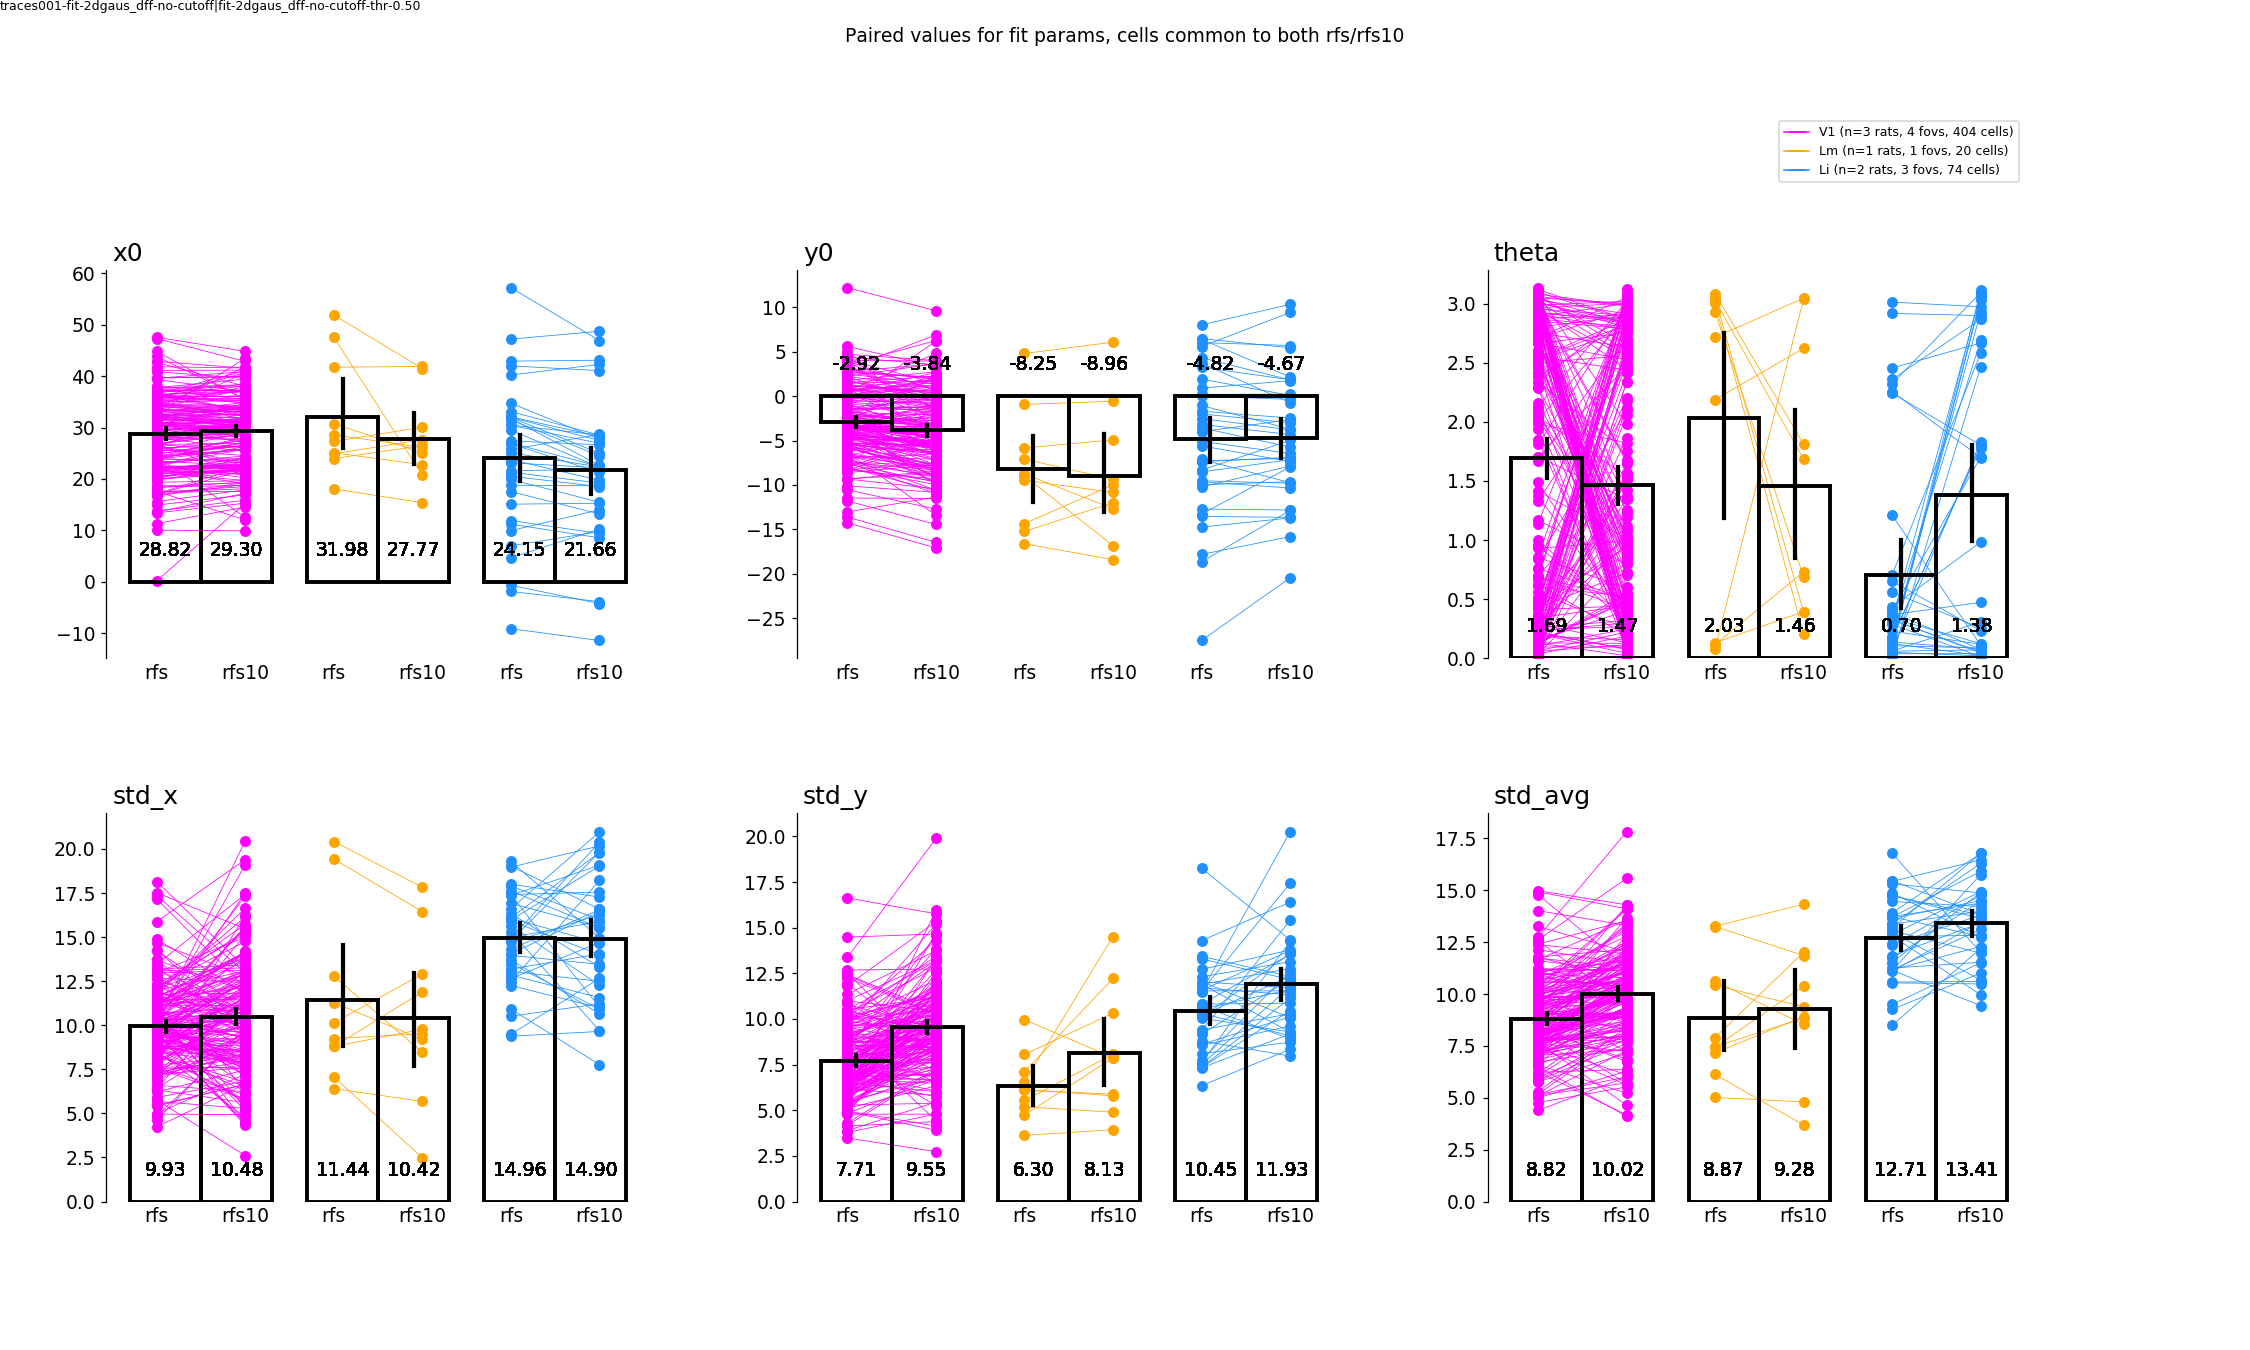

x0--------------
V1: (t-stat:-2.46, p=0.01)
Lm: (t-stat:1.48, p=0.17)
Li: (t-stat:4.22, p=0.00)
y0--------------
V1: (t-stat:5.83, p=0.00)
Lm: (t-stat:0.63, p=0.55)
Li: (t-stat:-0.36, p=0.72)
theta--------------
V1: (t-stat:1.90, p=0.06)
Lm: (t-stat:1.00, p=0.35)
Li: (t-stat:-3.42, p=0.00)
std_x--------------
V1: (t-stat:-2.71, p=0.01)
Lm: (t-stat:1.17, p=0.27)
Li: (t-stat:0.13, p=0.90)
std_y--------------
V1: (t-stat:-11.58, p=0.00)
Lm: (t-stat:-1.93, p=0.09)
Li: (t-stat:-3.28, p=0.00)
std_avg--------------
V1: (t-stat:-10.66, p=0.00)
Lm: (t-stat:-0.59, p=0.57)
Li: (t-stat:-2.06, p=0.05)
('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10_2', 'fitparams_cells-common-to-both-condns_std')


In [45]:
#split_components = False
sz_metric = 'std'

offset = 0.25
marker= 'o'

params = ['x0', 'y0', 'theta', '%s_x' % sz_metric, '%s_y' % sz_metric, '%s_avg' % sz_metric]
#sz_metric = 'f' if split_components else 'sigma_'
#params.extend(['%sx' % sz_metric, '%sy' % sz_metric])
    

fig, axn = pl.subplots(2, 3, figsize=(20,12), dpi=dpi)
fig.patch.set_alpha(0)

for ax, curr_metric in zip(axn.flat, params):

    ax.patch.set_alpha(0)
    
    # Plot paired values
    print("%s--------------" % curr_metric)
    ax = pairwise_compare_single_metric(comdf, curr_metric=curr_metric, ax=ax)
    
    ax.set_title(curr_metric, loc='left', fontsize=16)
    ax.set_ylabel('')

    # Annotate bars
    comdf.apply(aggr.annotateBars, ax=ax, axis=1)
    
# Adjust figure size
pl.subplots_adjust(left=0.05, right=0.9, top=0.8, wspace=0.3, hspace=0.4)
label_figure(fig, data_id)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(comdf, area_colors=area_colors, markersize=10, marker='_')
ax.legend(handles=legend_elements, bbox_to_anchor=(1, 2.8), fontsize=8)

fig.suptitle('Paired values for fit params, cells common to both rfs/rfs10')

# Save
figname = 'fitparams_cells-common-to-both-condns_%s' % (sz_metric)
pl.savefig(os.path.join(compare_dir, '%s.svg' % figname))

print(compare_dir, figname)    

In [124]:
# curr_metric = 'avg_size'

# fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
# fig.patch.set_alpha(0)
# ax.patch.set_alpha(0)

# ax = pairwise_compare_single_metric(comdf, curr_metric='avg_size', ax=ax)

# # Set x labels
# ax.set_ylim([0, 50])
    
# # Adjust figure size
# pl.subplots_adjust(left=0.12, right=0.7, top=0.8)
# label_figure(fig, data_id)

# # Get counts of samples for legend
# legend_elements = aggr.get_counts_for_legend(comdf, area_colors=area_colors, markersize=10, marker='_')
# ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.2), fontsize=8)

# # Save
# # figname = '%s_cells-common-to-both-condns' % curr_metric
# # pl.savefig(os.path.join(compare_dir, '%s.svg' % figname))

# # print(compare_dir, figname)    

# Check counts (N cells fit by experiment type)

<IPython.core.display.Javascript object>


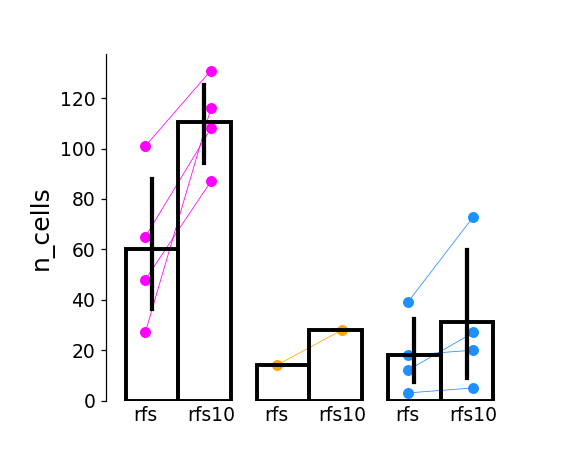

V1: (t-stat:-3.81, p=0.03)
Lm: (t-stat:nan, p=nan)
Li: (t-stat:-1.75, p=0.18)


In [47]:
countdf_all = df.groupby([ 'experiment', 'visual_area', 'animalid', 'datakey']).count()['cell'].reset_index()
countdf_all.rename(columns={'cell': 'n_cells'}, inplace=True)


curr_metric = 'n_cells'

fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax = pairwise_compare_single_metric(countdf_all, curr_metric=curr_metric, ax=ax)
pl.subplots_adjust(left=0.2)
# Set x labels
#ax.set_ylim([0, 50])

#### Plot join between rfs/rfs10

<IPython.core.display.Javascript object>


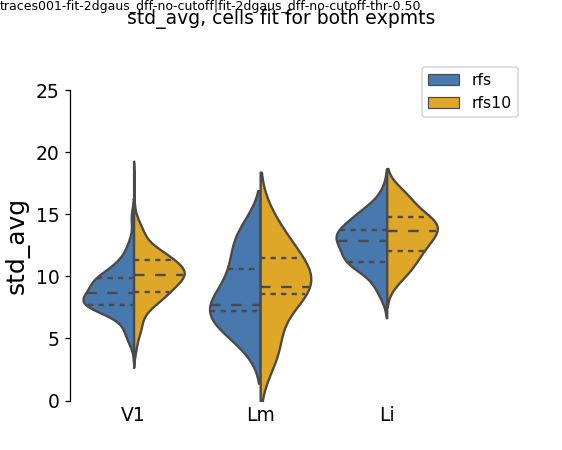

In [49]:
curr_metric = 'std_avg'

ylim = 50 if 'fwhm' in curr_metric else 25
currcols = ['windows blue', 'amber']
bi_palette = sns.xkcd_palette(currcols)

fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

sns.violinplot(x='visual_area', y=curr_metric, data=comdf, ax=ax,
               order=visual_areas,
              hue='experiment', palette=bi_palette, split=True,
               inner='quartile', scale='count')

ax.set_ylim([0, ylim])
ax.tick_params(axis='x', size=0)
ax.set_xlabel('')

fig.suptitle('%s, cells fit for both expmts' % curr_metric)
pl.subplots_adjust(right=0.8, top=0.8)
label_figure(fig, data_id)

ax.legend(bbox_to_anchor=(1.2, 1.1))
sns.despine(bottom=True, trim=True)

#### Calculate difference between rfs/rfs10 for size

In [125]:
# diffs = []
# for v, vdf in comdf.groupby(['visual_area']):
#     a_vals = vdf[vdf['experiment']=='rfs'][curr_metric].values
#     b_vals = vdf[vdf['experiment']=='rfs10'][curr_metric].values
#     diffs.append(pd.DataFrame({'visual_area': [v for _ in np.arange(0, len(a_vals))],
#                                'difference': b_vals - a_vals}))
# diffs = pd.concat(diffs, axis=0)


# fig, ax = pl.subplots()
# sns.stripplot(x='visual_area', y='difference', data=diffs,
#               order=visual_areas, palette=area_colors, ax=ax)

In [50]:
params = ['x0', 'y0', 'theta', '%s_x' % sz_metric, '%s_y' % sz_metric, '%s_avg' % sz_metric]

<IPython.core.display.Javascript object>


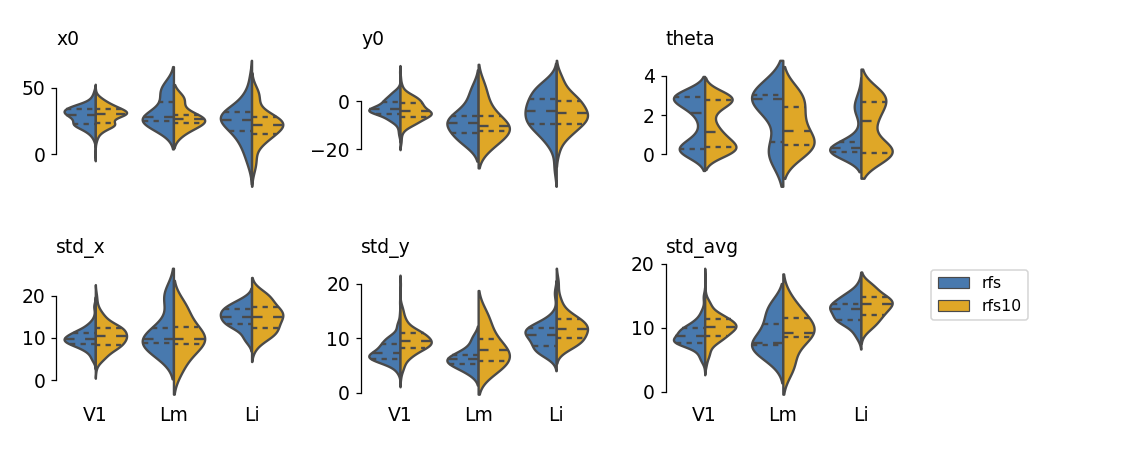

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10_2', 'all-metrics_cells-common-to-both-condns_std')


In [51]:
currcols = ['windows blue', 'amber']
bi_palette = sns.xkcd_palette(currcols)

fig, axes = pl.subplots(2, 3, figsize=(10,4), dpi=dpi)
fig.patch.set_alpha(0)

for ai, (ax, param) in enumerate(zip(axes.flat, params)):
    sns.violinplot(x='visual_area', y=param, data=comdf, ax=ax,
                   order=visual_areas,
                  hue='experiment', palette=bi_palette, split=True,
                   scale='count', inner='quartile')
    if ai < 5:
        ax.legend_.remove()
    else:
        ax.legend(bbox_to_anchor=(1.1, 1))
    if ai<3:
        ax.set_xticklabels('')
    ax.set_xlabel('')
    ax.tick_params(axis='x', size=0)
    sns.despine(trim=True, ax=ax, bottom=True)
    ax.set_ylabel('')
    ax.set_title(param, fontsize=12, loc='left')
    
pl.subplots_adjust(wspace=0.3, hspace=0.5, right=0.8, left=0.05)


# Save
figname = 'all-metrics_cells-common-to-both-condns_%s' % sz_metric
pl.savefig(os.path.join(compare_dir, '%s_2svg' % figname))

print(compare_dir, figname)    

In [52]:
reload(aggr)
reload(ret)

<module 'pipeline.python.classifications.retino_structure' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/retino_structure.pyc'>

# Visualize general stats

In [53]:
scale_sigma = True


### Check size distns for ALL dataset

In [54]:
# set output dir
filter_by = 'drop_repeats'
genstats_dir = os.path.join(outdir, 'general-stats', filter_by)
if not os.path.exists(genstats_dir):
    os.makedirs(genstats_dir)
print genstats_dir

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats


In [62]:
filter_by = None

#### Get metadata
r_df_nof, dkey_dict_nof = rfutils.aggregate_rf_dataframes(filter_by, traceid=traceid, 
                                                          fit_desc='fit-2dgaus_dff-no-cutoff',
                                                          reliable_only=reliable_only,
                                                          fov_type=fov_type, state=state, stimulus='rfs')

# dsets_nof = aggr.get_metadata(traceid=traceid, fov_type=fov_type, state=state, 
#                               filter_by=filter_by, stimulus='rfs')
# rfdata_nof = dsets_nof[dsets_nof['experiment'].isin(['rfs', 'rfs10'])].copy()

# #### Check for any datasets that need RF fits
# excluded_sessions = ['JC110_20191004_FOV1_zoom2p0x',
#                      'JC080_20190602_FOV1_zoom2p0x',
#                      'JC113_20191108_FOV1_zoom2p0x', 'JC113_20191108_FOV2_zoom2p0x']
# rf_dpaths_nof, _ = rfutils.get_fit_dpaths(rfdata_nof, traceid=traceid, fit_desc=fit_desc, 
#                                           excluded_sessions=excluded_sessions)

# #### Get RF dataframe for all datasets (filter to include only good fits)
# all_df_nof = rfutils.aggregate_rf_data(rf_dpaths_nof, scale_sigma=scale_sigma, verbose=False,
#                                       fit_desc=fit_desc, traceid=traceid)
# all_df_nof.groupby(['visual_area', 'experiment'])['datakey'].count()

# #### Filter for good fits only
# r_df_nof= all_df_nof[all_df_nof['rvisual_areas = ['V1', 'Lm', 'Li']
# colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
# area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}
# 2'] > fit_thr].copy().reset_index(drop=True)
# dkey_dict_nof = dict((v, dict((dk, di) for di, dk in enumerate(vdf['datakey'].unique()))) \
#                  for v, vdf in r_df_nof.groupby(['visual_area'])) 
# r_df_nof['datakey_ix'] = [dkey_dict_nof[r_df_nof['visual_area'][i]][r_df_nof['datakey'][i]] \
#                       for i in r_df_nof.index.tolist()]    
    
    

Selecting 63 dsets
N dpaths: 70, N unfit: 0
N datasets included: 70, N sessions excluded: 4


<IPython.core.display.Javascript object>


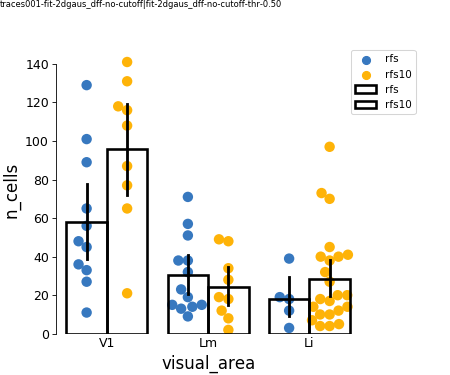

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10_2', 'N_cells_fit_by_area_ALL')


In [63]:
r_df_nof
countdf_all = r_df_nof.groupby([ 'experiment', 'visual_area', 'animalid', 'datakey']).count()['cell'].reset_index()
countdf_all.rename(columns={'cell': 'n_cells'}, inplace=True)


curr_metric = 'n_cells'

# g = sns.catplot(x='visual_area', hue='experiment',y='n_cells', data=countdf_all, 
#             kind='swarm', dodge=True, palette=bi_palette)
# Set x labels
fig, ax = pl.subplots(figsize=(6,5))
sns.swarmplot(x='visual_area', y='n_cells', hue='experiment', data=countdf_all, 
              dodge=True, palette=bi_palette, ax=ax, size=10, zorder=0,
             order=['V1', 'Lm', 'Li'])
sns.barplot(x='visual_area', y='n_cells', hue='experiment', data=countdf_all, ax=ax,
              facecolor=(1, 1, 1, 0), order=['V1', 'Lm', 'Li'],
            errcolor="k", edgecolor=('k', 'k', 'k'), linewidth=2.5)
sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)
label_figure(fig, data_id)
pl.legend(bbox_to_anchor=((1.2, 1)))
pl.subplots_adjust(right=0.8)


figname = 'N_cells_fit_by_area_ALL'
pl.savefig(os.path.join(compare_dir, '%s.svg' % figname))
print(compare_dir, figname)


In [60]:
genstats_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats'

<IPython.core.display.Javascript object>


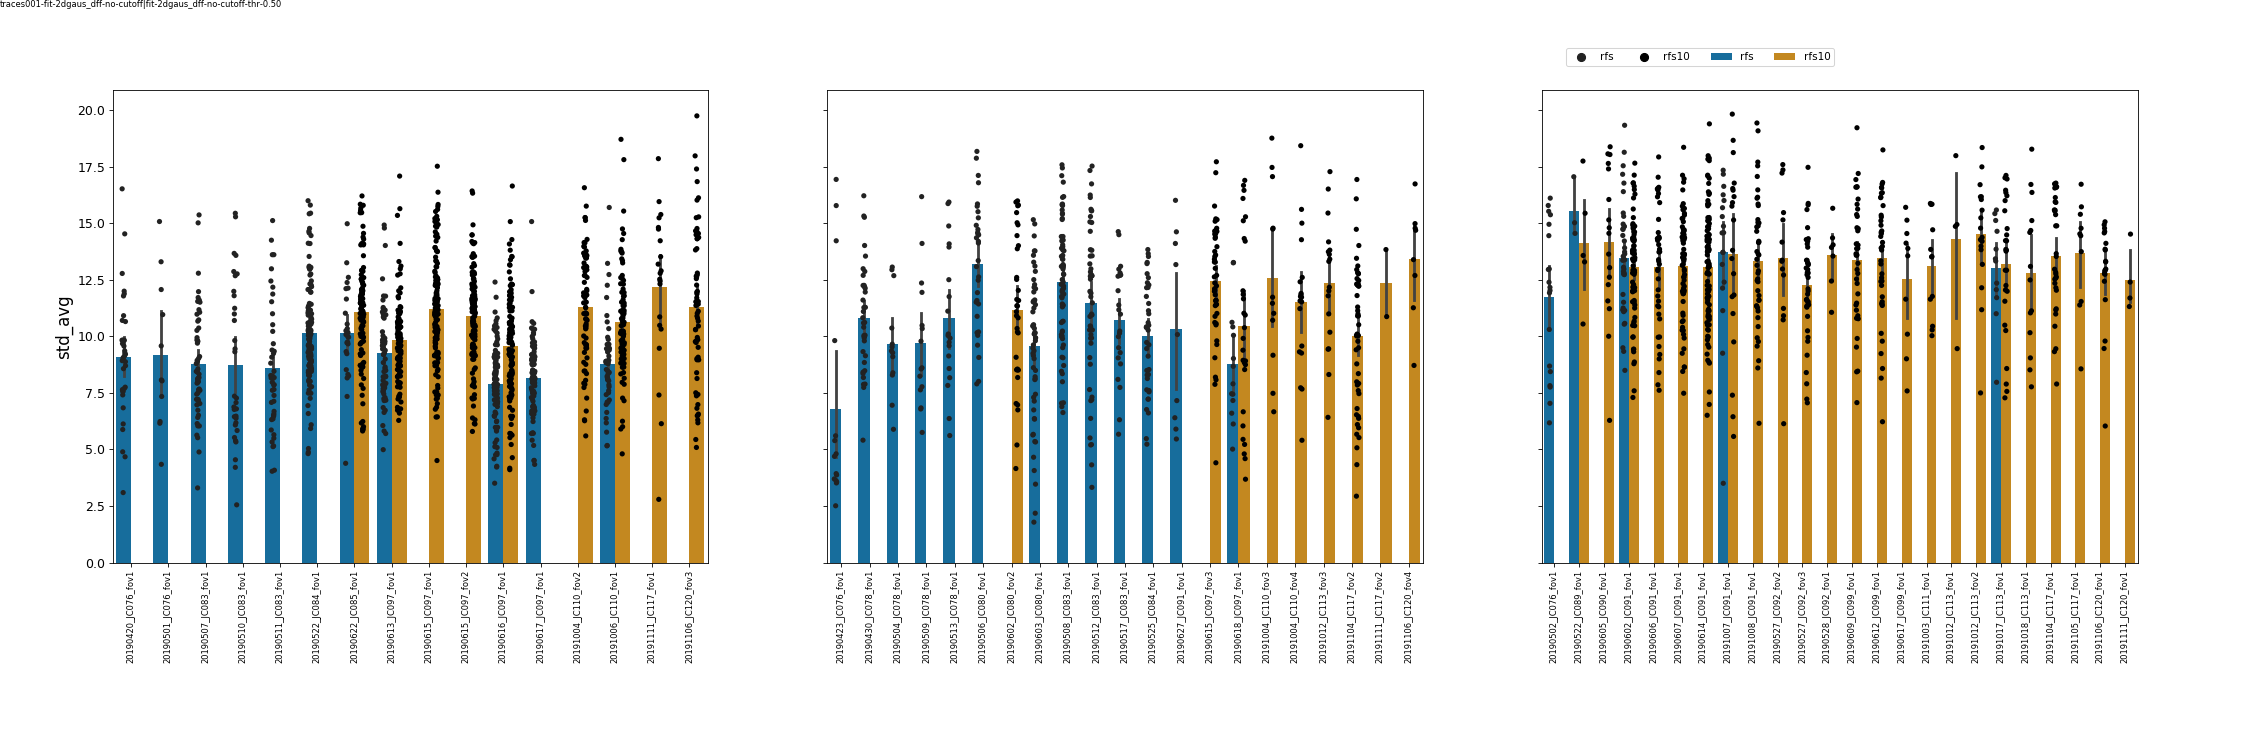

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats', 'std_avg_by-dataset_by-experiment_ALL')


In [64]:

sz_metric = 'std'
curr_metric = '%s_avg' % sz_metric

fig, axes = pl.subplots(1,3, figsize=(30, 10), sharey=True)
for ai, (ax, visual_area) in enumerate(zip(axes.flat, visual_areas)):
    
    plotdf = r_df_nof[r_df_nof['visual_area']==visual_area]
    curr_datakeys = sorted(plotdf['datakey'].unique(), key=natural_keys)
    
    #xvs = [dkey_dict[dk] for dk in curr_datakeys]
    plotdf['xv'] = [dkey_dict_nof[visual_area][dk] for dk in plotdf['datakey']]
    
    sns.stripplot(x='xv', y=curr_metric, hue='experiment', data=plotdf, ax=ax,
                 dodge=True, color='k')
    
    sns.barplot(x='xv', y=curr_metric, hue='experiment', data=plotdf, ax=ax,
                 palette='colorblind')
    
    dkey_labels = [dk for dk, di in sorted(dkey_dict_nof[visual_area].items(), key=lambda x: x[1])]
    
    ax.set_xticklabels(dkey_labels, rotation=90, fontsize=8)
    ax.set_xlabel('')
    if ai != 0:
        ax.set_ylabel('')
        
    if ai != 2:
        ax.legend_.remove()
    else:
        ax.legend(bbox_to_anchor=(0.5, 1.1), ncol=4)
pl.subplots_adjust(bottom=0.25, left=0.05, right=0.95, wspace=0.2)

label_figure(fig, data_id)
figname = '%s_by-dataset_by-experiment_ALL' % (curr_metric)
pl.savefig(os.path.join(outdir, 'general-stats', '%s.svg' % figname))
print(genstats_dir, figname)

## Drop repeats

In [67]:
#### How to deal with repeat FOVs (manual)
filter_by = 'drop_repeats'
r_df, dkey_dict = rfutils.aggregate_rf_dataframes(filter_by, traceid=traceid, fov_type=fov_type, 
                                                  reliable_only=reliable_only,
                                                  fit_desc='fit-2dgaus_dff-no-cutoff',
                                                  state=state, stimulus='rfs')

Selecting 42 dsets
N dpaths: 48, N unfit: 0
N datasets included: 48, N sessions excluded: 4


In [68]:
# filter_by = None

# #### Get metadata
# dsets = aggr.get_metadata(traceid=traceid, fov_type=fov_type, state=state, 
#                               filter_by=filter_by, stimulus='rfs')
# rfdata = dsets[dsets['experiment'].isin(['rfs', 'rfs10'])]
# rfdata.groupby(['visual_area', 'experiment']).count()

# #### Check for any datasets that need RF fits
# excluded_sessions = ['JC110_20191004_FOV1_zoom2p0x',
#                     'JC080_20190602_FOV1_zoom2p0x']
# rf_dpaths, nostats = get_fit_dpaths(rfdata, fit_desc=fit_desc, excluded_sessions=excluded_sessions)
# print(nostats)

# #### Get RF dataframe for all datasets (filter to include only good fits)
# all_df = aggregate_rf_data(rf_dpaths, verbose=False, scale_sigma=scale_sigma)
# all_df.groupby(['visual_area', 'experiment'])['datakey'].count()


# r_df = all_df[all_df['r2'] > fit_thr].copy().reset_index(drop=True)
# dkey_dict = dict((v, dict((dk, di) for di, dk in enumerate(vdf['datakey'].unique()))) \
#                  for v, vdf in r_df.groupby(['visual_area'])) 
# r_df['datakey_ix'] = [dkey_dict[r_df['visual_area'][i]][r_df['datakey'][i]] \
#                       for i in r_df.index.tolist()]    
    
    

<IPython.core.display.Javascript object>


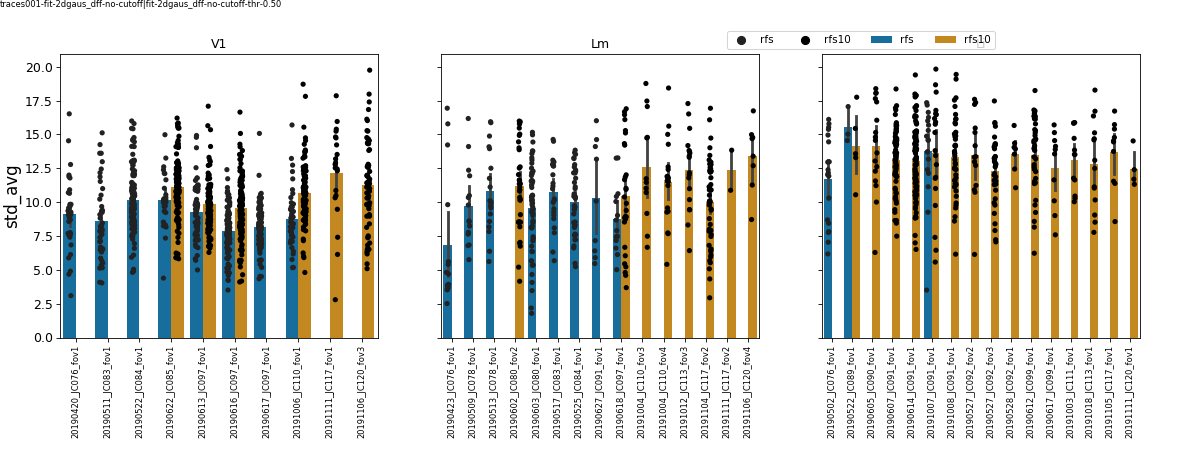

In [70]:
curr_metric = '%s_avg' % sz_metric
fig, axes = pl.subplots(1,3, figsize=(16, 6), sharey=True)
for ai, (ax, visual_area) in enumerate(zip(axes.flat, visual_areas)):
    plotdf = r_df[r_df['visual_area']==visual_area]
    curr_datakeys = sorted(plotdf['datakey'].unique(), key=natural_keys)
    
    #xvs = [dkey_dict[dk] for dk in curr_datakeys]
    plotdf['xv'] = [dkey_dict[visual_area][dk] for dk in plotdf['datakey']]
    
    sns.stripplot(x='xv', y='%s_avg' % sz_metric, hue='experiment', data=plotdf, ax=ax,
                 dodge=True, color='k')
    
    sns.barplot(x='xv', y='%s_avg' % sz_metric, hue='experiment', data=plotdf, ax=ax,
                 palette='colorblind')
    
    dkey_labels = [dk for dk, di in sorted(dkey_dict[visual_area].items(), key=lambda x: x[1])]
    
    ax.set_xticklabels(dkey_labels, rotation=90, fontsize=8)
    ax.set_xlabel('')
    if ai != 0:
        ax.set_ylabel('')
    
    ax.set_title(visual_area)
    
    if ai != 2:
        ax.legend_.remove()
    else:
        ax.legend(bbox_to_anchor=(0.56, 1.1), ncol=4)
pl.subplots_adjust(bottom=0.25, left=0.05, right=0.95)

label_figure(fig, data_id)
figname = '%s_by-dataset_by-experiment_%s' % (curr_metric, filter_by)
pl.savefig(os.path.join(outdir, 'general-stats', '%s.svg' % figname))


In [71]:
all_df[all_df['r2']>0.5].groupby(['visual_area', 'experiment']).count()

NameError: name 'all_df' is not defined

In [173]:
all_df[(all_df['visual_area']=='Lm') & (all_df['experiment']=='rfs10')].count()

r2             250
sigma_x        250
sigma_y        250
theta          250
x0             250
y0             250
animalid       250
cell           250
datakey        250
experiment     250
session        250
visual_area    250
avg_size       250
dtype: int64

# Get datasets to analyze

In [101]:
# Make sure only 1 experiment type per dset
rdf_list=[]
for (visual_area, datakey), g in r_df.groupby(['visual_area', 'datakey']):
    expname = 'rfs' if visual_area=='V1' else 'rfs10'
    altname = 'rfs' if expname=='rfs10' else 'rfs10'
    
    vdf = g[g['experiment']==expname]
#     if len(vdf)==0:
#         vdf = g[g['experiment']==altname]
    rdf_list.append(vdf)
    
rdf = pd.concat(rdf_list)

# rdf = pd.concat([vdf[vdf['experiment']=='rfs10'] if v=='Li' else vdf[vdf['experiment']=='rfs'] \
#     for v, vdf in all_df.groupby(['visual_area'])])
rfdf = rdf[rdf['r2']>fit_thr]
rfdf.groupby(['visual_area']).count()

,r2,sigma_x,sigma_y,theta,x0,y0,animalid,cell,datakey,experiment,session,avg_size,datakey_ix
visual_area,,,,,,,,,,,,,
Li,386,386,386,386,386,386,386,386,386,386,386,386,386
Lm,151,151,151,151,151,151,151,151,151,151,151,151,151
V1,495,495,495,495,495,495,495,495,495,495,495,495,495


In [174]:
# Make sure only 1 experiment type per dset
rdf_list=[]
for (visual_area, datakey), g in r_df.groupby(['visual_area', 'datakey']):
    expname = 'rfs' if visual_area=='V1' else 'rfs10'
    altname = 'rfs' if expname=='rfs10' else 'rfs10'
    
    vdf = g[g['experiment']==expname]
#     if len(vdf)==0:
#         vdf = g[g['experiment']==altname]
    rdf_list.append(vdf)
    
rdf = pd.concat(rdf_list)

# rdf = pd.concat([vdf[vdf['experiment']=='rfs10'] if v=='Li' else vdf[vdf['experiment']=='rfs'] \
#     for v, vdf in all_df.groupby(['visual_area'])])
rfdf = rdf[rdf['r2']>fit_thr]
rfdf.groupby(['visual_area']).count()

,r2,sigma_x,sigma_y,theta,x0,y0,animalid,cell,datakey,experiment,session,avg_size
visual_area,,,,,,,,,,,,
Li,386,386,386,386,386,386,386,386,386,386,386,386
Lm,166,166,166,166,166,166,166,166,166,166,166,166
V1,495,495,495,495,495,495,495,495,495,495,495,495


In [104]:
reload(rfutils)

<module 'pipeline.python.classifications.rf_utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/rf_utils.py'>

## 1. Average RF size

<IPython.core.display.Javascript object>


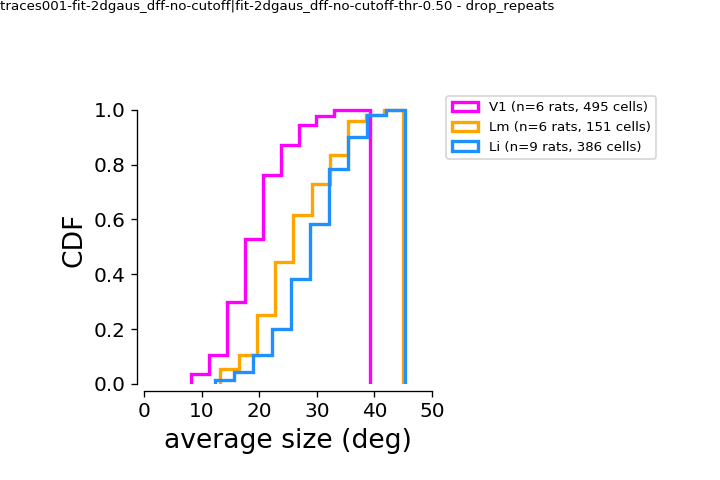

avg_size_drop_repeats_cdf


In [105]:
curr_metric = 'avg_size'
cdf = True
plot_type = 'cdf' if cdf else 'hist'
max_size = 50 if scale_sigma else 30
#for experiment, expdf in rfdf.groupby(['experiment']):

fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
ax = rfutils.compare_rf_size(rfdf, cdf=cdf, ax=ax, alpha=1, area_colors=area_colors)
ax.set_xlim([0, max_size])
sns.despine(ax=ax, trim=True, offset=4)

pl.subplots_adjust(right=0.6, top=0.8, bottom=0.2, left=0.2)

label_figure(fig, '%s - %s' % (data_id, filter_by))
figname = '%s_%s_%s' % (curr_metric, filter_by, plot_type)
pl.savefig(os.path.join(genstats_dir, '%s_2.svg' % figname))
print(figname)

## 2. Bar plot for fov averages

<IPython.core.display.Javascript object>


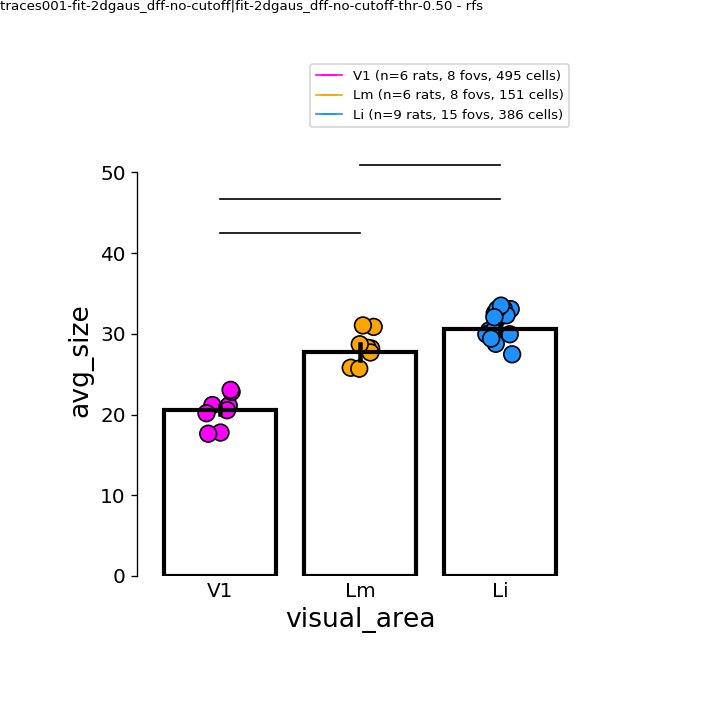

********* rfs - avg_size **********
[('V1', 'Lm')] Statistics=14960.000, p=0.000, ... Different distribution (reject H0)
[('V1', 'Li')] Statistics=22207.000, p=0.000, ... Different distribution (reject H0)
[('Lm', 'Li')] Statistics=21656.000, p=0.000, ... Different distribution (reject H0)
[(('V1', 'Lm'), True, 6.1030881560329455e-29), (('V1', 'Li'), True, 4.4230317262061704e-85), (('Lm', 'Li'), True, 1.8175141291548127e-06)]
42.48
****************************
avg_size_fwhm_groupby-datakey_mean-fov_drop_repeats__multicomp-holm_ci


In [107]:
curr_metric = 'avg_size'
multi_comp_test = 'holm'
mean_metric = 'mean'
groupby = 'datakey'

# for experiment, expdf in rfdf.groupby(['experiment']):

# Average RF sizes for each FOV
if groupby is not None:
    grped = rfdf.groupby(['visual_area', groupby])
    group_str = 'groupby-%s' % groupby
else:
    grped = rfdf.groupby(['visual_area'])
    group_str = ''


if mean_metric == 'median':
    mean_sizes = grped.median()['avg_size'].reset_index()
else:
    mean_sizes = grped.mean()['avg_size'].reset_index()

fig, ax = pl.subplots(figsize=(6,6), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

sns.barplot(x="visual_area", y=curr_metric, data=rfdf, 
            ax=ax, order=visual_areas, ci=95,
            errcolor="k", edgecolor=('k', 'k', 'k'), 
            facecolor=(1,1,1,0), linewidth=2.5)

sns.stripplot(x='visual_area', y=curr_metric, data=mean_sizes, 
              zorder=0,
              ax=ax, #hue='cond',
              s=10, palette=area_colors, 
              order=visual_areas, 
              color=(1,1,1,0), 
              dodge=True,
              #facecolor=(1,1,1,0),
              edgecolor='k',
              marker='o',linewidth=1)

print("********* %s - %s **********" % (experiment, curr_metric))
statresults = aggr.do_mannwhitney(rfdf, metric=curr_metric, multi_comp_test=multi_comp_test)
print(statresults)
# stats significance
aggr.annotate_stats_areas(statresults, ax=ax)
print("****************************")

#ax.set_ylim([-1, 40])
pl.subplots_adjust(top=0.8, bottom=0.2, left=0.2, right=0.8)
sns.despine(offset=4, trim=True, bottom=True)
ax.tick_params(axis='x', size=0)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(rfdf, area_colors=area_colors, markersize=10, marker='_')
ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.2), fontsize=8)


label_figure(fig, '%s - %s' % (data_id, experiment))
figname = '%s_%s_%s_%s-fov_%s__multicomp-%s_ci' % (curr_metric, sigma_str, group_str, mean_metric, filter_by, multi_comp_test)
pl.savefig(os.path.join(genstats_dir, '%s_2.svg' % figname))
print(figname)

In [108]:

print("********* %s - %s **********" % (experiment, curr_metric))
statresults = aggr.do_mannwhitney(mean_sizes, metric=curr_metric, multi_comp_test=multi_comp_test)
print(statresults)
# stats significance
#annotate_stats_areas(statresults, ax)
print("****************************")

********* rfs - avg_size **********
[('V1', 'Lm')] Statistics=0.000, p=0.000, ... Different distribution (reject H0)
[('V1', 'Li')] Statistics=0.000, p=0.000, ... Different distribution (reject H0)
[('Lm', 'Li')] Statistics=18.000, p=0.004, ... Different distribution (reject H0)
[(('V1', 'Lm'), True, 0.0009391056991171899), (('V1', 'Li'), True, 0.00018401959621917283), (('Lm', 'Li'), True, 0.0036941768465627383)]
****************************


## Distn of all rf sizes

<IPython.core.display.Javascript object>


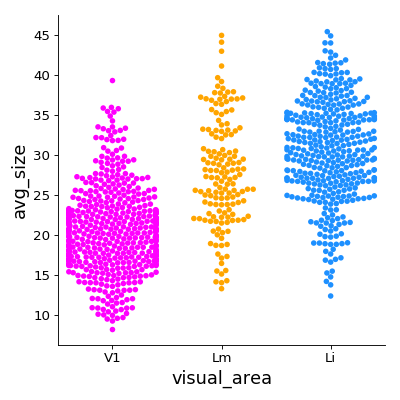

avg-size-distns_fwhm_combine-all_by-area_swarm


In [181]:
plot_kind = 'swarm'
fg = sns.catplot(x="visual_area", y="avg_size", data=rfdf,# col='experiment',
           palette=area_colors, order=visual_areas, kind=plot_kind, dodge=True, 
                 edgecolor='w', linewidth=0, alpha=1)

figname = 'avg-size-distns_%s_combine-all_by-area_%s' % (sigma_str, plot_kind)
fg.fig.savefig(os.path.join(genstats_dir, '%s_2.svg' % figname))
print(figname)

## Look at N cells fit 

In [182]:
countdf = rfdf.groupby([ 'visual_area', 'animalid', 'datakey']).count()['cell'].reset_index()
countdf.rename(columns={'cell': 'n_cells'}, inplace=True)


<IPython.core.display.Javascript object>


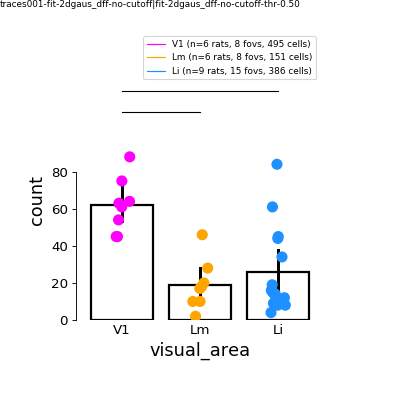

********* rfs - n_cells **********
[('V1', 'Lm')] Statistics=2.000, p=0.001, ... Different distribution (reject H0)
[('V1', 'Li')] Statistics=11.500, p=0.001, ... Different distribution (reject H0)
[('Lm', 'Li')] Statistics=59.000, p=0.487, ... Same distribution (fail to reject H0)
[(('V1', 'Lm'), True, 0.0028736476934448779), (('V1', 'Li'), True, 0.0028736476934448779), (('Lm', 'Li'), False, 0.48712006533324409)]
112.08
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats', 'n_cells_avg-fov_drop_repeats__multicomp-holm')


In [183]:
curr_metric = 'n_cells'
fg = sns.catplot(x="visual_area", y=curr_metric, data=countdf, #hue="experiment", 
               kind = 'bar',
                errcolor="k", edgecolor=('k', 'k', 'k'), order=visual_areas,
                facecolor=(1,1,1,0), linewidth=2, zorder=0, legend=0) #, ax=ax)
sns.stripplot(x='visual_area', y=curr_metric, data=countdf, #hue='experiment',
             order=visual_areas, ax=fg.ax, palette=area_colors, dodge=True,
             size=10)
fg.ax.tick_params(axis='x', size=0)
fg.ax.set_ylabel('count')


#ax.set_ylim([-1, 40])
pl.subplots_adjust(top=0.8, bottom=0.2, left=0.2, right=0.8)
sns.despine(offset=4, trim=True, bottom=True, ax=fg.ax)
fg.ax.tick_params(axis='x', size=0)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(rfdf, area_colors=area_colors, markersize=10, marker='_')
fg.ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.2), fontsize=8)


print("********* %s - %s **********" % (experiment, curr_metric))
statresults = aggr.do_mannwhitney(countdf, metric=curr_metric, multi_comp_test=multi_comp_test)
print(statresults)
# stats significance
aggr.annotate_stats_areas(statresults, ax=fg.ax)
print("****************************")

    
#fg.ax.set_title('N cells with good fits(within 95% CI)', loc='left')
label_figure(fg.fig, data_id)

figname = '%s_avg-fov_%s__multicomp-%s' % (curr_metric, filter_by, multi_comp_test)
fg.fig.savefig(os.path.join(genstats_dir, '%s_2.svg' % figname))

print(genstats_dir, figname)


## All fit params

In [571]:
params

['x0', 'y0', 'theta', 'sigma_x', 'sigma_y', 'avg_size']

<IPython.core.display.Javascript object>


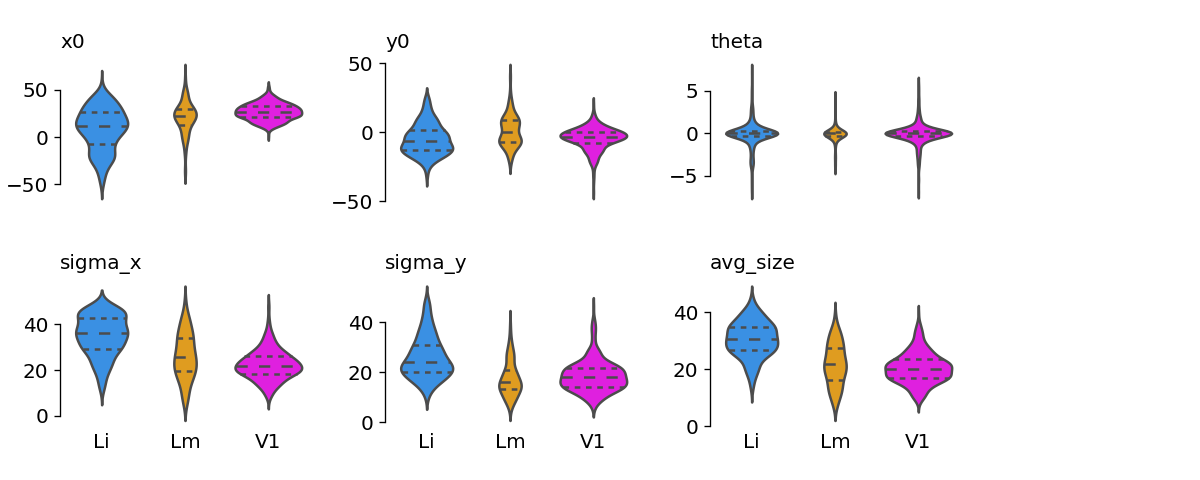

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10', 'all-metrics_drop_repeats_fwhm')


In [216]:
plot_type = 'violin'

fig, axes = pl.subplots(2, 3, figsize=(10,4), dpi=dpi)
fig.patch.set_alpha(0)

for ai, (ax, param) in enumerate(zip(axes.flat, params)):
    if plot_type=='violin':
        sns.violinplot(x='visual_area', y=param, data=rfdf, ax=ax,
                      palette=area_colors,
                       scale='count', inner='quartile')
    else:
        sns.swarmplot(x='visual_area', y=param, data=rfdf, ax=ax,
                      palette=area_colors, dodge=True)
    if ai<3:
        ax.set_xticklabels('')
    ax.set_xlabel('')
    ax.tick_params(axis='x', size=0)
    sns.despine(trim=True, ax=ax, bottom=True)
    ax.set_ylabel('')
    ax.set_title(param, fontsize=12, loc='left')
    
pl.subplots_adjust(wspace=0.3, hspace=0.5, right=0.8, left=0.05)


# Save
figname = 'all-metrics_%s_%s' % (filter_by, sigma_str)
pl.savefig(os.path.join(genstats_dir, '%s_2.svg' % figname))

print(compare_dir, figname)    